# Описание обучения

### Данные

1. Берутся только id героев как фичи

### Обучение

1. Для **ML подходов:** \
Конкатинируются в вектор длины $ 2 * len(unique(id)) $ \
Для Radiant - $ len(unique(id)) $ \
Для Dire - $ len(unique(id)) $

2. Для **DL подходов:** ?

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/Users/ankamenskiy/SmartDota/')

In [2]:
import pickle
import dataclasses
import json

import pandas as pd
import numpy as np
import torch

import matplotlib.pyplot as plt

from src.data.api.OpenDota.pro_matches_dataloader import ProMatchesDataloader
from src.data.api.OpenDota.public_matches_dataloader import PublicMatchesDataloader

/Users/ankamenskiy/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Читаем данные

In [3]:
train_path = '/Users/ankamenskiy/SmartDota/cache/public_110000_7-34b-ALL'
test_path = '/Users/ankamenskiy/SmartDota/cache/pro_10000_dups'

train_dataloader = PublicMatchesDataloader(0, 0)
train_dataloader.load(path=train_path)
test_dataloader = ProMatchesDataloader()
test_dataloader.load(path=test_path)

train_data = train_dataloader.data
test_data = test_dataloader.data

print(len(train_data), len(test_data))

Empty Key
Last match index: 7504377105
Last match index: 7502042193
110000 10000


In [26]:
import json
import dataclasses

d = dataclasses.asdict(test_data[0])

with open('a.json', 'w') as f:
    f.write(json.dumps(d))

## Готовим датасет

### For PUBLIC matches [TRAIN data]

In [8]:
df_train_val = pd.DataFrame()

df_train_val['target'] = [1 if match.radiant_win else 0 for match in train_data]
df_train_val['radiant_hero_ids'] = [match.radiant_team for match in train_data]
df_train_val['dire_hero_ids'] = [match.dire_team for match in train_data]

df_train_val.dropna(inplace=True)
display(df_train_val.sample(5))
df_train_val.groupby('target')['target'].count()

,target,radiant_hero_ids,dire_hero_ids
17952,0,"[31, 74, 93, 53, 98]","[110, 94, 7, 3, 20]"
33733,1,"[48, 1, 114, 129, 37]","[69, 78, 13, 94, 27]"
53530,1,"[98, 71, 48, 91, 101]","[113, 27, 11, 100, 21]"
40986,1,"[13, 53, 62, 67, 64]","[123, 14, 26, 45, 93]"
59662,0,"[7, 56, 126, 109, 26]","[101, 54, 87, 69, 76]"


target
0    45230
1    50499
Name: target, dtype: int64

### For PRO matches [TEST data]

0 - Radiant \
1 - Dire

In [9]:
pb = [elem.picks_bans for elem in test_data]

radiants, dires, targets = [], [], []

for i, elem in enumerate(test_data):
    pb = elem.picks_bans
    target = elem.pro_match_data.radiant_win # 1 if RADIANT win | 0 if DIRE win

    if pb is None or target is None:
        continue
    
    pb = sorted(filter(lambda x: x.is_pick, pb), key=lambda x: x.team)
    assert len(pb) == 10

    radiants.append([e.hero_id for e in pb[:5]])
    dires.append([e.hero_id for e in pb[5:]])
    targets.append(int(target))

df_test = pd.DataFrame()

df_test['target'] = targets
df_test['radiant_hero_ids'] = radiants
df_test['dire_hero_ids'] = dires

display(df_test.sample(5))
display(df_test.isna().sum())
df_test.groupby('target')['target'].count()

,target,radiant_hero_ids,dire_hero_ids
9075,1,"[45, 5, 98, 93, 52]","[100, 65, 14, 43, 35]"
1303,0,"[61, 110, 129, 86, 70]","[21, 71, 126, 10, 2]"
7188,0,"[53, 129, 101, 10, 128]","[97, 26, 46, 102, 114]"
9778,0,"[20, 21, 100, 113, 45]","[53, 26, 87, 61, 98]"
9214,1,"[20, 100, 21, 39, 15]","[121, 102, 112, 29, 90]"


target              0
radiant_hero_ids    0
dire_hero_ids       0
dtype: int64

target
0    4767
1    5141
Name: target, dtype: int64

In [10]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer(sparse_output=True)

def make_hero_onehot(df):
    df1 = df.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(df.pop('radiant_hero_ids')),
                index=df.index,
                columns=mlb.classes_
            )
        )
    # display(df1)

    df2 = df1.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(df1.pop('dire_hero_ids')),
                index=df1.index,
                columns=mlb.classes_
            ),
            lsuffix='_radiant', 
            rsuffix='_dire'
        )
    # display(df2)
    
    return df2

df_train_val = make_hero_onehot(df_train_val).drop_duplicates()
df_test = make_hero_onehot(df_test).drop_duplicates()

display(df_train_val)
display(df_test)

,target,1_radiant,2_radiant,3_radiant,4_radiant,5_radiant,6_radiant,7_radiant,8_radiant,9_radiant,...,120_dire,121_dire,123_dire,126_dire,128_dire,129_dire,135_dire,136_dire,137_dire,138_dire
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95730,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95731,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95738,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95739,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,target,1_radiant,2_radiant,3_radiant,4_radiant,5_radiant,6_radiant,7_radiant,8_radiant,9_radiant,...,120_dire,121_dire,123_dire,126_dire,128_dire,129_dire,135_dire,136_dire,137_dire,138_dire
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,1,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9903,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9904,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9905,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9906,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

RANDOM_STATE = 42

X = df_train_val.drop(['target'], axis=1).to_numpy()
y = df_train_val['target'].to_numpy()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05, random_state=RANDOM_STATE)

X_test = df_test.drop(['target'], axis=1).to_numpy()
y_test = df_test['target'].to_numpy()

### Help functions

In [12]:
def plot_prob_hist(probas):
    dire_win, radiant_win = probas[:, 0], probas[:, 1]
    
    plt.hist(dire_win, color='r', alpha = 0.3, bins=40)
    plt.hist(radiant_win, color='g', alpha = 0.6, bins=40)

def compare_results(y_pred, y_true, X_val):
    df = pd.DataFrame()
    df['y_pred'] = y_pred
    df['y_true'] = y_true
    display(df)

def make_prediction(model, heroes):
    df = pd.DataFrame()
    df['radiant_hero_ids'] = heroes['radiant']
    df['dire_hero_ids'] = heroes['dire']

    df = make_hero_onehot(df)
    X_pred = df.to_numpy()

    probas = model.predict_proba(X_pred)
    print(probas)
    probas = np.exp(probas) / np.sum(np.exp(probas)) # softmax

    return {
        'dire': probas[0],
        'radiant': probas[1]
    }

# LogReg

In [13]:
from sklearn.linear_model import LogisticRegression

logreg_model = LogisticRegression()
logreg_model.fit(X_train, y_train)

LogisticRegression()

,y_pred,y_true
0,0,1
1,0,1
2,1,1
3,1,1
4,0,1
...,...,...
4736,1,1
4737,1,1
4738,0,1
4739,1,1


              precision    recall  f1-score   support

           0       0.57      0.41      0.48      2247
           1       0.58      0.72      0.64      2494

    accuracy                           0.57      4741
   macro avg       0.57      0.56      0.56      4741
weighted avg       0.57      0.57      0.56      4741



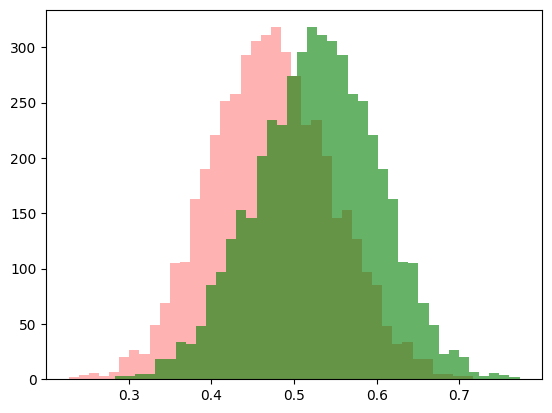

In [14]:
preds = logreg_model.predict(X_val)
probas = logreg_model.predict_proba(X_val)

plot_prob_hist(probas)
compare_results(preds, y_val, X_val)
print(classification_report(y_val, preds))

# Catboost

In [17]:
from catboost import CatBoostClassifier


cbt_model = CatBoostClassifier(
                iterations=30_000,                
                learning_rate=3e-3,
                depth=3
            )

cbt_model.fit(
    X_train,
    y_train,
    eval_set=(X_val, y_val),
    plot=True,
    silent=True,
    use_best_model=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

,preds,prob_dire,prob_radiant,X_test,y_test
0,1,0.394255,0.605745,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
3,0,0.603765,0.396235,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
4,1,0.437307,0.562693,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",0
5,1,0.290635,0.709365,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
7,1,0.434701,0.565299,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
...,...,...,...,...,...
4079,1,0.373473,0.626527,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
4084,1,0.439276,0.560724,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
4085,1,0.427637,0.572363,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
4087,0,0.584680,0.415320,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1


(1891, 2)


,y_pred,y_true
0,1,0
1,0,0
2,1,0
3,1,0
4,1,1
...,...,...
1886,1,1
1887,1,0
1888,1,1
1889,0,1


              precision    recall  f1-score   support

           0       0.56      0.33      0.41       894
           1       0.56      0.77      0.65       997

    accuracy                           0.56      1891
   macro avg       0.56      0.55      0.53      1891
weighted avg       0.56      0.56      0.54      1891

Lost 0.538 samples


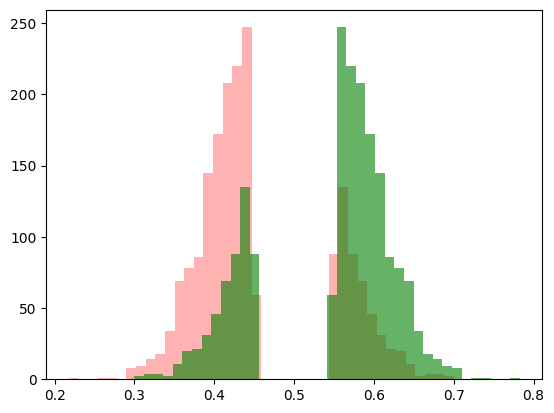

In [51]:
THRESHOLD = 0.55

df = pd.DataFrame()

preds = cbt_model.predict(X_test)
probas = cbt_model.predict_proba(X_test)

df['preds'] = preds.tolist()
df['prob_dire'] = probas[:, 0].tolist()
df['prob_radiant'] = probas[:, 1].tolist()
df['X_test'] = X_test.tolist()
df['y_test'] = y_test.tolist()

df_thr = df[(df['prob_dire'] > THRESHOLD) | (df['prob_radiant'] > THRESHOLD)]
display(df_thr)

probas_thr = np.concatenate(
    (
        df_thr['prob_dire'].to_numpy().reshape(-1, 1), 
        df_thr['prob_radiant'].to_numpy().reshape(-1, 1)
    ), axis=1)
print(probas_thr.shape)
preds_thr = df_thr['preds'].to_numpy()
X_test_thr = df_thr['X_test'].to_numpy()
y_test_thr = df_thr['y_test'].to_numpy()

plot_prob_hist(probas_thr)
compare_results(preds_thr, y_test_thr, X_test_thr)
print(classification_report(y_test_thr, preds_thr))
print(f'Lost {1 - df_thr.shape[0] / df.shape[0]:.3f} samples')

[1 0 0 ... 1 0 1]
[1 0 0 ... 1 0 1]


,y_pred,y_true
0,1,1
1,0,0
2,0,0
3,0,0
4,1,1
...,...,...
1977,1,1
1978,1,1
1979,1,1
1980,0,0


              precision    recall  f1-score   support

           0       0.90      0.92      0.91       946
           1       0.92      0.91      0.91      1036

    accuracy                           0.91      1982
   macro avg       0.91      0.91      0.91      1982
weighted avg       0.91      0.91      0.91      1982



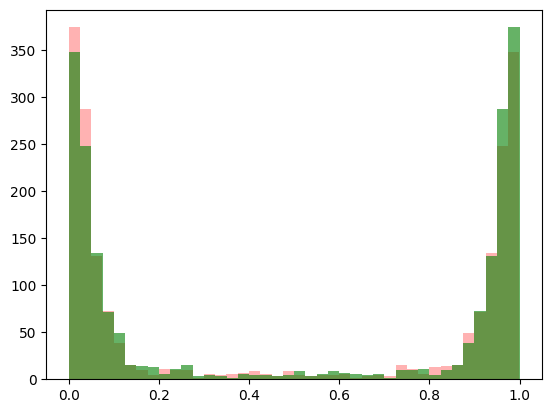

In [ ]:
preds = cbt_model.predict(X_val)
probas = cbt_model.predict_proba(X_val)

plot_prob_hist(probas)
compare_results(preds, y_val, X_val)
print(classification_report(y_val, preds))

In [15]:
model_name = 'HeroIds_0.91-F1.cbm'

cbt_model.save_model(
    fname='/Users/ankamenskiy/SmartDota/models/catboost/' + model_name,
    format="cbm"
)

In [33]:
import json
import sys
sys.path.append('../')

from lib.results_view import make_single_prediction

# print('LogReg:\n', make_single_prediction(logreg_model, 7599378829))
print('-'*50)
print('CatBoost:\n', make_single_prediction(cbt_model, 7599358486))

--------------------------------------------------
CatBoost:
 {'result': 'Radiant', 'dire': '0.28', 'radiant': '0.72'}
